In [1]:
# Import packages
import sys
import os

import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

import tqdm

import torch
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn as nn

from IPython.display import clear_output
from IPython import display

%matplotlib inline

# check and use GPU if available if not use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# CODE from another notebook
class NeuralNet(torch.nn.Module):
    def __init__(self, input_size, output_size, activation, layers=[32,32,16]):
        super().__init__()

        # Define layers with ReLU activation
        self.linear1 = torch.nn.Linear(input_size, layers[0])
        self.activation1 = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(layers[0], layers[1])
        self.activation2 = torch.nn.ReLU()
        self.linear3 = torch.nn.Linear(layers[1], layers[2])
        self.activation3 = torch.nn.ReLU()

        self.output_layer = torch.nn.Linear(layers[2], output_size)
        self.output_activation = activation

        # Initialization using Xavier normal (a popular technique for initializing weights in NNs)
        torch.nn.init.xavier_normal_(self.linear1.weight)
        torch.nn.init.xavier_normal_(self.linear2.weight)
        torch.nn.init.xavier_normal_(self.linear3.weight)
        torch.nn.init.xavier_normal_(self.output_layer.weight)

    def forward(self, inputs):
        # Forward pass through the layers
        x = self.activation1(self.linear1(inputs))
        x = self.activation2(self.linear2(x))
        x = self.activation3(self.linear3(x))
        x = self.output_activation(self.output_layer(x))
        return x

def generate_single_episode(env, policy_net):
    """
    Generates an episode by executing the current policy in the given env
    """
    states = []
    actions = []
    rewards = []
    log_probs = []
    max_t = 1000 # max horizon within one episode
    state, _ = env.reset()
        
    for t in range(max_t):
        state = torch.from_numpy(state).float().unsqueeze(0)
        probs = policy_net.forward(Variable(state)) # get each action choice probability with the current policy network
        action = np.random.choice(env.action_space.n, p=np.squeeze(probs.detach().numpy())) # probablistic
        # action = np.argmax(probs.detach().numpy()) # greedy
        
        # compute the log_prob to use this in parameter update
        log_prob = torch.log(probs.squeeze(0)[action])
        
        # append values
        states.append(state)
        actions.append(action)
        log_probs.append(log_prob)
        
        # take a selected action
        state, reward, terminated, truncated, _ = env.step(action)
        rewards.append(reward)

        if terminated | truncated:
            break
            
    return states, actions, rewards, log_probs

def evaluate_policy(env, policy_net):
    """
    Compute accumulative trajectory reward
    """
    states, actions, rewards, log_probs = generate_single_episode(env, policy_net)
    return np.sum(rewards)

In [3]:
def train_PPO(env, policy_net, policy_optimizer, value_net, value_optimizer, num_epochs, clip_val=0.2, gamma=0.99):
    """
    Trains the policy network using PPO
    """

    # Generate an episode with the current policy network
    states, actions, rewards, log_probs = generate_single_episode(env, policy_net)
    T = len(states)
    
    # Create tensors
    states = np.vstack(states).astype(float)
    states = torch.FloatTensor(states).to(device)
    actions = torch.LongTensor(actions).to(device).view(-1,1)
    rewards = torch.FloatTensor(rewards).to(device).view(-1,1)
    log_probs = torch.FloatTensor(log_probs).to(device).view(-1,1)

    # Compute total discounted return at each time step
    Gs = []
    G = 0
    for t in range(T-1,-1,-1): # iterate in backward order to make the computation easier
        G = rewards[t] + gamma*G
        Gs.insert(0,G)
    Gs = torch.tensor(Gs).view(-1,1)
    
    # Compute the advantage
    state_vals = value_net(states).to(device)
    with torch.no_grad():
        A_k = Gs - state_vals
        
    for _ in range(num_epochs):
        V = value_net(states).to(device)
        
        # Calculate probability of each action under the updated policy
        probs = policy_net.forward(states).to(device)
        
                
        # compute the log_prob to use it in parameter update
        curr_log_probs = torch.log(torch.gather(probs, 1, actions)) # Use torch.gather(A,1,B) to select columns from A based on indices in B
        
        # Calculate ratios r(theta)
        ratios = torch.exp(curr_log_probs - log_probs)
        
        # Calculate two surrogate loss terms in cliped loss
        surr1 = ratios * A_k
        surr2 = torch.clamp(ratios, 1-clip_val, 1+clip_val) * A_k
        
        # Calculate clipped loss value
        actor_loss = (-torch.min(surr1, surr2)).mean() # Need negative sign to run Gradient Ascent
        
        # Update policy network
        policy_optimizer.zero_grad()
        actor_loss.backward(retain_graph=True)
        policy_optimizer.step()
        
        # Update value net
        critic_loss = nn.MSELoss()(V, Gs)
        value_optimizer.zero_grad()
        critic_loss.backward()
        value_optimizer.step()
        
    return policy_net, value_net


/Users/kajratbekbolinov/anaconda3/lib/python3.11/site-packages/gymnasium/envs/registration.py:513: DeprecationWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(
  0%|          | 0/5 [00:00<?, ?it/s]/Users/kajratbekbolinov/anaconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Episode: 0
The avg. test reward for episode 0 is 21.3 with std of 15.271214751944262.
Episode: 50
The avg. test reward for episode 50 is 35.0 with std of 12.841339493993608.
Episode: 100
The avg. test reward for episode 100 is 25.8 with std of 4.7286361670147565.
Episode: 150
The avg. test reward for episode 150 is 24.75 with std of 3.5899164335677787.
Episode: 200
The avg. test reward for episode 200 is 40.55 with std of 8.102314484145873.
Episode: 250
The avg. test reward for episode 250 is 116.2 with std of 21.414014102918674.
Episode: 300
The avg. test reward for episode 300 is 156.3 with std of 27.716601523274818.
Episode: 350
The avg. test reward for episode 350 is 109.6 with std of 45.4526126861812.
Episode: 400
The avg. test reward for episode 400 is 184.15 with std of 27.907481075869246.
Episode: 450
The avg. test reward for episode 450 is 200.0 with std of 0.0.
Episode: 500
The avg. test reward for episode 500 is 200.0 with std of 0.0.
Episode: 550
The avg. test reward for ep

 20%|██        | 1/5 [00:21<01:27, 21.83s/it]

Episode: 0
The avg. test reward for episode 0 is 15.55 with std of 5.286539510870981.
Episode: 50
The avg. test reward for episode 50 is 9.3 with std of 0.714142842854285.
Episode: 100
The avg. test reward for episode 100 is 9.55 with std of 0.5894913061275798.
Episode: 150
The avg. test reward for episode 150 is 9.65 with std of 0.6538348415311012.
Episode: 200
The avg. test reward for episode 200 is 9.25 with std of 0.82915619758885.
Episode: 250
The avg. test reward for episode 250 is 9.35 with std of 0.5722761571129799.
Episode: 300
The avg. test reward for episode 300 is 9.75 with std of 0.7664854858377946.
Episode: 350
The avg. test reward for episode 350 is 9.35 with std of 0.7262919523166975.
Episode: 400
The avg. test reward for episode 400 is 9.45 with std of 0.9205976319760983.
Episode: 450
The avg. test reward for episode 450 is 9.3 with std of 0.7810249675906654.
Episode: 500
The avg. test reward for episode 500 is 9.35 with std of 0.9630680142129111.
Episode: 550
The avg.

 40%|████      | 2/5 [00:28<00:39, 13.09s/it]

Episode: 0
The avg. test reward for episode 0 is 19.2 with std of 8.405950273467004.
Episode: 50
The avg. test reward for episode 50 is 27.5 with std of 10.007497189607399.
Episode: 100
The avg. test reward for episode 100 is 23.4 with std of 5.314132102234568.
Episode: 150
The avg. test reward for episode 150 is 81.7 with std of 21.286380622360394.
Episode: 200
The avg. test reward for episode 200 is 137.65 with std of 24.938474291744473.
Episode: 250
The avg. test reward for episode 250 is 181.9 with std of 22.871160880025307.
Episode: 300
The avg. test reward for episode 300 is 198.15 with std of 8.063963045550246.
Episode: 350
The avg. test reward for episode 350 is 199.15 with std of 3.705064102009572.
Episode: 400
The avg. test reward for episode 400 is 193.45 with std of 16.662757874973757.
Episode: 450
The avg. test reward for episode 450 is 195.6 with std of 19.179155351578963.
Episode: 500
The avg. test reward for episode 500 is 175.65 with std of 19.588963729610608.
Episode:

 60%|██████    | 3/5 [00:53<00:36, 18.24s/it]

Episode: 0
The avg. test reward for episode 0 is 22.0 with std of 8.17312669668102.
Episode: 50
The avg. test reward for episode 50 is 12.4 with std of 1.4966629547095764.
Episode: 100
The avg. test reward for episode 100 is 37.05 with std of 6.931630399841007.
Episode: 150
The avg. test reward for episode 150 is 139.25 with std of 24.095383375244314.
Episode: 200
The avg. test reward for episode 200 is 193.2 with std of 18.980516325959098.
Episode: 250
The avg. test reward for episode 250 is 200.0 with std of 0.0.
Episode: 300
The avg. test reward for episode 300 is 180.25 with std of 49.38003138921643.
Episode: 350
The avg. test reward for episode 350 is 180.95 with std of 16.81212360173455.
Episode: 400
The avg. test reward for episode 400 is 200.0 with std of 0.0.
Episode: 450
The avg. test reward for episode 450 is 177.45 with std of 39.513889962897856.
Episode: 500
The avg. test reward for episode 500 is 198.85 with std of 4.186585721085859.
Episode: 550
The avg. test reward for 

 80%|████████  | 4/5 [01:17<00:20, 20.54s/it]

Episode: 0
The avg. test reward for episode 0 is 17.45 with std of 8.393300900122668.
Episode: 50
The avg. test reward for episode 50 is 28.1 with std of 12.837055737200801.
Episode: 100
The avg. test reward for episode 100 is 63.95 with std of 19.311848694519124.
Episode: 150
The avg. test reward for episode 150 is 197.45 with std of 11.115192306028717.
Episode: 200
The avg. test reward for episode 200 is 197.1 with std of 11.339753083731583.
Episode: 250
The avg. test reward for episode 250 is 158.15 with std of 52.59683925864748.
Episode: 300
The avg. test reward for episode 300 is 200.0 with std of 0.0.
Episode: 350
The avg. test reward for episode 350 is 197.6 with std of 10.461357464497619.
Episode: 400
The avg. test reward for episode 400 is 177.95 with std of 32.11459948372391.
Episode: 450
The avg. test reward for episode 450 is 200.0 with std of 0.0.
Episode: 500
The avg. test reward for episode 500 is 184.0 with std of 28.944775003444057.
Episode: 550
The avg. test reward fo

100%|██████████| 5/5 [01:40<00:00, 20.18s/it]


Text(0.5, 1.0, 'PPO Learning Curve')

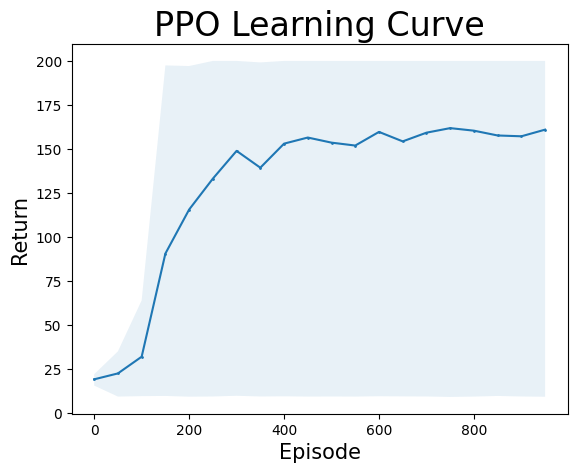

In [4]:
# Define parameter values
env_name = 'CartPole-v0'
num_train_ite = 1000
num_seeds = 5 # fit model with 5 different seeds and plot average performance of 5 seeds
num_epochs = 10 # how many times we iterate the entire training dataset passing through the training
eval_freq = 50 # run evaluation of policy at each eval_freq trials
eval_epi_index = num_train_ite//eval_freq # use to create x label for plot
returns = np.zeros((num_seeds, eval_epi_index))
gamma = 0.99 # discount factor
clip_val = 0.2 # hyperparameter epsilon in clip objective

# Create the environment.
env = gym.make(env_name)
nA = env.action_space.n
nS = 4

policy_lr = 5e-4 # policy network's learning rate 
baseline_lr = 1e-4 # value network's learning rate
 
for i in tqdm.tqdm(range(num_seeds)):
    reward_means = []

    # Define policy and value networks
    policy_net = NeuralNet(nS, nA, torch.nn.Softmax())
    policy_net_optimizer = optim.Adam(policy_net.parameters(), lr=policy_lr)
    value_net = NeuralNet(nS, 1, torch.nn.ReLU())
    value_net_optimizer = optim.Adam(value_net.parameters(), lr=baseline_lr)
    
    for m in range(num_train_ite):
        # Train networks with PPO
        policy_net, value_net = train_PPO(env, policy_net, policy_net_optimizer, value_net, value_net_optimizer, num_epochs, clip_val=clip_val, gamma=gamma)
        if m % eval_freq == 0:
            print("Episode: {}".format(m))
            G = np.zeros(20)
            for k in range(20):
                g = evaluate_policy(env, policy_net)
                G[k] = g

            reward_mean = G.mean()
            reward_sd = G.std()
            print("The avg. test reward for episode {0} is {1} with std of {2}.".format(m, reward_mean, reward_sd))
            reward_means.append(reward_mean)
    returns[i] = np.array(reward_means)

# Plot the performance over iterations
x = np.arange(eval_epi_index)*eval_freq
avg_returns = np.mean(returns, axis=0)
max_returns = np.max(returns, axis=0)
min_returns = np.min(returns, axis=0)

plt.fill_between(x, min_returns, max_returns, alpha=0.1)
plt.plot(x, avg_returns, '-o', markersize=1)

plt.xlabel('Episode', fontsize = 15)
plt.ylabel('Return', fontsize = 15)

plt.title("PPO Learning Curve", fontsize = 24)

    

In [7]:
l = [
0.037,
-0.148,
0.098,
0.022,
0.492,
0.632,
0.557,
0.539,
0.759,
0.586,
0.728,
0.571,
0.225,
0.427,
0.596,
0.722,
0.581,
0.658,
0.563,
0.645,
0.623,
0.576,
0.547,
0.448,
0.613,
0.474,
0.693]

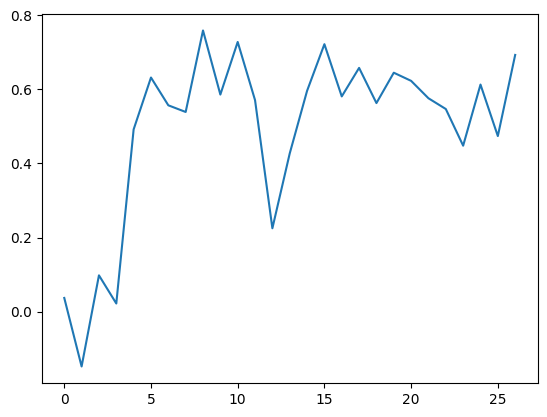

In [8]:
l = np.array(l)
plt.plot(np.arange(len(l)), l)
plt.show()

In [11]:
k = [
-0.063,
0.058,
-0.151,
0.109,
0.674,
0.606,
0.784,
0.542,
0.838,
0.712,
0.692,
0.634,
0.840,
0.789,
0.717,
0.717,
0.767,
0.834,
0.639]

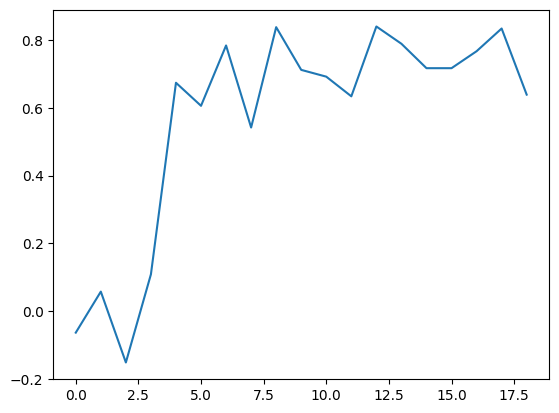

In [12]:
k = np.array(k)
plt.plot(np.arange(len(k)), k)
plt.show()